# 인물사진을 만들어 보자 [프로젝트]
---

1. 인물사진 모드를 만들어 보고,
2. 결과물의 문제점과,
3. 해결방안 제시

<details>
<summary> > 루브릭 </summary>
<div markdown="1">  

|평가문항	|상세기준|
|---|---|
|1. 인물모드 사진을 성공적으로 제작하였다.|	아웃포커싱 효과가 적용된 인물모드 사진과 동물 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다.|
|2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.|	인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.|
|3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.|	semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 이유와 함께 제시하였다.|

</div>
</details>

In [1]:
# 라이브러리 준비

import os
import urllib    # URL 작업을 위한 여러 모듈을 모은 패키지.
import cv2
import numpy as np

from pixellib.semantic import semantic_segmentation   # semantic segmentation을 쉽게 사용할 수 있도록 만든 라이브러리
from matplotlib import pyplot as plt

In [2]:
# 모델 준비 (DeepLabV3+)

# 모델 파일 저장
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'  
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 
urllib.request.urlretrieve(model_url, model_file)

# 다운로드한 모델을 이용해 사용할 모델 생성
model = semantic_segmentation() 
model.load_pascalvoc_model(model_file) 

In [3]:
# pascalvoc 데이터(deeplab 학습데이터)의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

for i in enumerate(LABEL_NAMES):
    print(i)

(0, 'background')
(1, 'aeroplane')
(2, 'bicycle')
(3, 'bird')
(4, 'boat')
(5, 'bottle')
(6, 'bus')
(7, 'car')
(8, 'cat')
(9, 'chair')
(10, 'cow')
(11, 'diningtable')
(12, 'dog')
(13, 'horse')
(14, 'motorbike')
(15, 'person')
(16, 'pottedplant')
(17, 'sheep')
(18, 'sofa')
(19, 'train')
(20, 'tv')


## Step 1. 인물모드 만들어보기
---
1. 이미지 로딩 
2. blurring, concat
3. 크로마키 

In [4]:
# 원본이미지 로딩
def img_load(img_name, label_index):
    '''
    args:
        img_name(str) : image file 이름
        label_index(int) : pascalvoc에 포함된 데이터 라벨 인덱스
    '''
    img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/'+ img_name  
    img_orig = cv2.imread(img_path)
    segvalues, output = model.segmentAsPascalvoc(img_path) # model이 object detect -> output에 저장
    
    #컬러맵 만들기 
    colormap = np.zeros((256, 3), dtype = int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3
    
    # 색상순서 변경 (BGR -> RGB)
    seg_color = (colormap[label_index][::-1]) 
    
    # seg_map은 output 이미지에서 seg_color와 일치하는 부분이 True로, 일치하지 않는 부분이 False로 표시된 불리언 배열이 됩니다
    seg_map = np.all(output==seg_color, axis=-1)
    
    # True과 False인 값을 각각 255과 0으로 바꿔줍니다
    img_mask = seg_map.astype(np.uint8) * 255

    return img_mask


In [5]:
# 배경 blurring

def img_bg_blur(img_name, label_index):
    '''
    args
        img_name(str) : 원본 이미지 파일명(img_load의 img_name과 동일)
        label_index(int) : pascalvoc label index
    '''
    img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/'+ img_name  
    img_orig = cv2.imread(img_path)
    
    # img blur 처리 함수
    img_orig_blur = cv2.blur(img_orig, (13,13))
    
    # 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
    img_mask_color = cv2.cvtColor(img_load(img_name, label_index), cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)

    # 이미지 합치기
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    
    return img_concat


In [6]:
# 테스트

img_concat = img_bg_blur('me.JPG', 15)

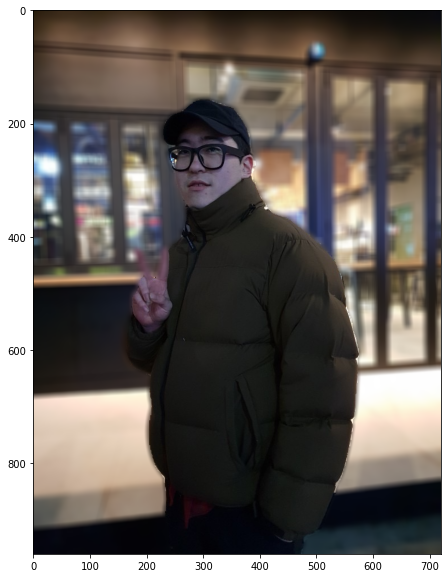

In [7]:
# 출력

plt.figure(figsize=(10, 10)) 
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

In [8]:
# 여러 사진 담아보기

img_concat1 = img_bg_blur('me.JPG', 15)
img_concat2 = img_bg_blur('goyoonjung.png', 15)
img_concat3 = img_bg_blur('leetaekjo.png', 15)
img_concat_king = img_bg_blur('king.png', 12)


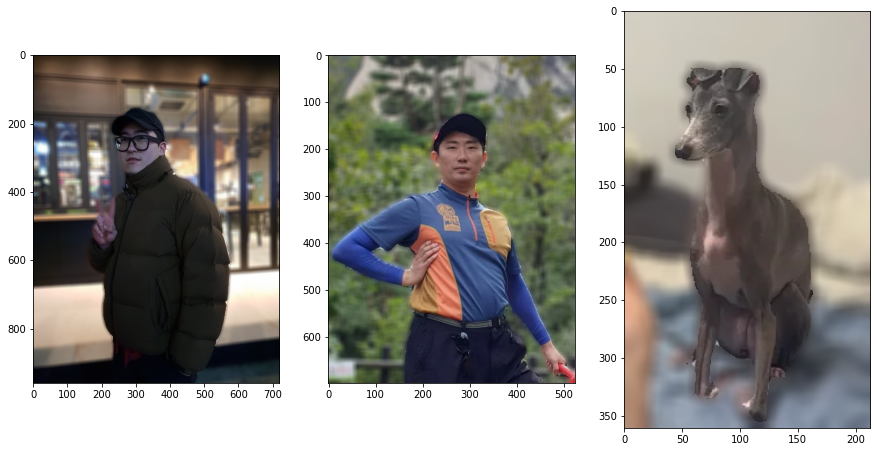

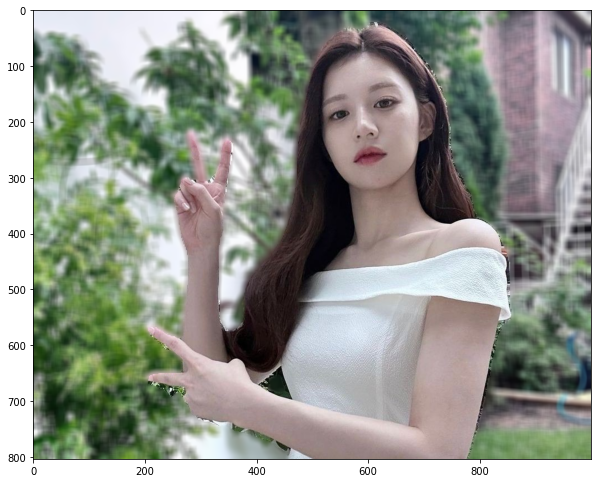

In [9]:
# 확인

plt.figure(figsize = (15,20))

plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(img_concat1, cv2.COLOR_BGR2RGB))

plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(img_concat3, cv2.COLOR_BGR2RGB))

plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(img_concat_king, cv2.COLOR_BGR2RGB))
plt.show()

plt.figure(figsize = (10,10))
plt.imshow(cv2.cvtColor(img_concat2, cv2.COLOR_BGR2RGB))
plt.show()


"예쁘다"

In [10]:
# 크로마키?

def bg_chromakey(img_name1, img_name2, label_index):
    '''
    args:
        img_name1(str) : object 포함 이미지
        img_name2(str) : background image
        label_index(int) : pascalvoc label index
    '''
    
    # object
    img_path1 = os.getenv('HOME')+'/aiffel/human_segmentation/images/'+ img_name1 #goyoonjung.png
    img_orig1 = cv2.imread(img_path1)
    
    # background
    img_path2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/'+ img_name2 #moving.png
    img_orig2 = cv2.imread(img_path2)
    
    # resize
    new_height = img_orig1.shape[0]
    new_width = img_orig1.shape[1]
    resized_image = cv2.resize(img_orig2, (new_width, new_height))

    # 마스크이미지불러오고 배경이랑 합치기
    img_mask_color = cv2.cvtColor(img_load(img_name1, label_index), cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg = cv2.bitwise_and(resized_image, img_bg_mask)   # size error -> cv2.resize로 해결
    
    img_concat = np.where(img_mask_color==255, img_orig1, img_bg)
    
    return img_concat
    

In [11]:
# 여러 사진 배경전환 

chromakey1 = bg_chromakey('goyoonjung.png', 'moving.png', 15)
chromakey2 = bg_chromakey('goyoonjung.png', 'fire.png', 15)
chromakey3 = bg_chromakey('king.png', 'fire.png', 12)

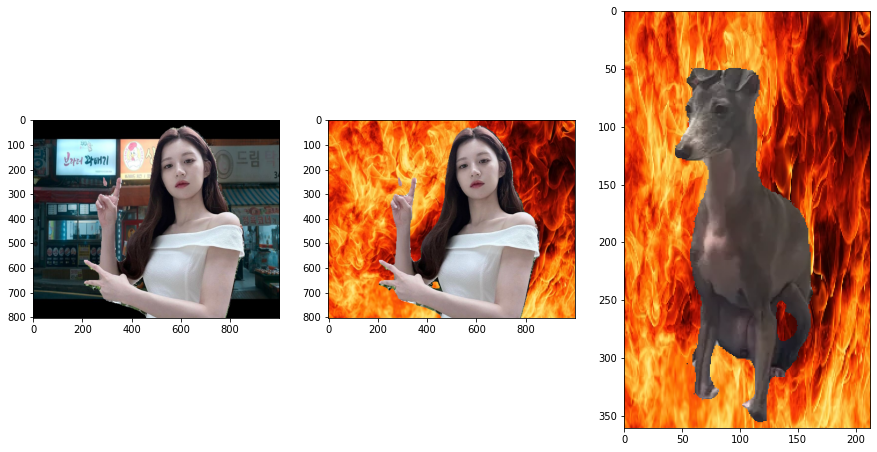

In [12]:
# 확인!

plt.figure(figsize=(15, 20)) 

plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(chromakey1, cv2.COLOR_BGR2RGB))

plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(chromakey2, cv2.COLOR_BGR2RGB))

plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(chromakey3, cv2.COLOR_BGR2RGB))

plt.show()

## Step 2. 문제점?
---
사람들 손가락을 못찾는다. 강아지 발이 망가졌다. 이미지의 경계부분이 확실하지않다...


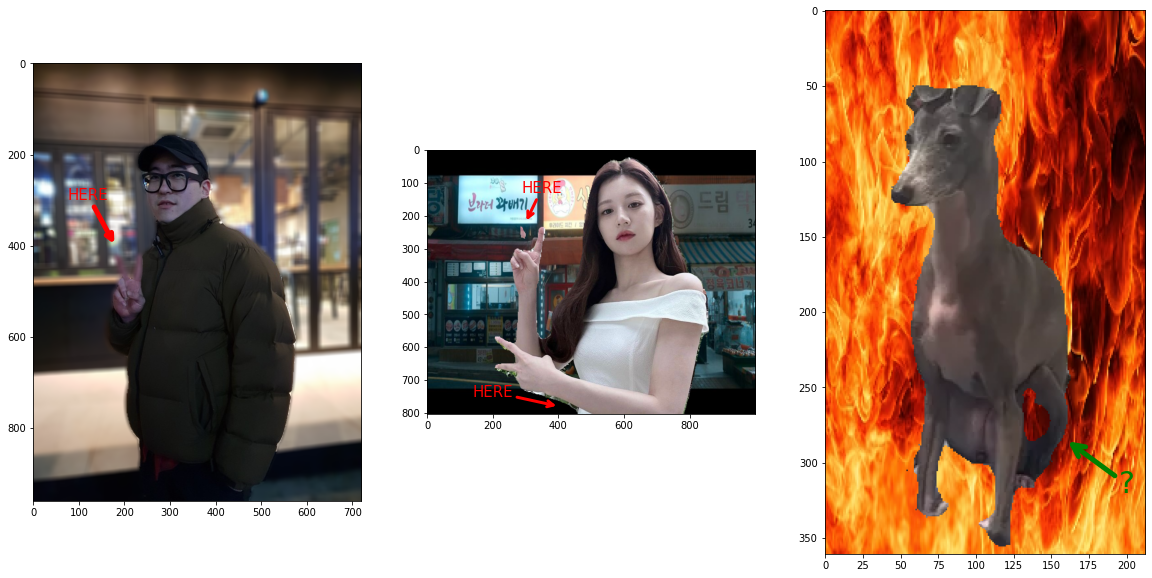

In [13]:
# 확인, 표시

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(img_concat1, cv2.COLOR_BGR2RGB))
plt.annotate('HERE',
             xytext=(120, 300),
             xy=(180, 400), 
             rotation=0, 
             color='red',
             ha='center', 
             va='baseline', 
             fontsize=15,
             arrowprops=dict(arrowstyle='->', color='red', lw=5)
            )

plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(chromakey1, cv2.COLOR_BGR2RGB))
plt.annotate('HERE',
             xytext=(350, 130),
             xy=(300, 220), 
             rotation=0, 
             color='red',
             ha='center', 
             va='baseline', 
             fontsize=15,
             arrowprops=dict(arrowstyle='->', color='red', lw=3)
            )
plt.annotate('HERE',
             xytext=(200, 750),
             xy=(400, 780), 
             rotation=0, 
             color='red',
             ha='center', 
             va='baseline', 
             fontsize=15,
             arrowprops=dict(arrowstyle='->', color='red', lw=3)
            )

plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(chromakey3, cv2.COLOR_BGR2RGB))
plt.annotate('?',
             xytext=(200, 320),
             xy=(160, 285), 
             rotation=0, 
             color='green',
             ha='center', 
             va='baseline', 
             fontsize=30,
             arrowprops=dict(arrowstyle='->', color='green', lw=5)
            )
plt.show()

## Step 3. 해결 방법 제안
---

아주 간단히 멋진 카메라 앱 서비스를 만들어 출시할 수 있을 것 같았지만, 지금 같은 완성도로는 어림도 없습니다. 소비자들의 눈높이는 그리 호락호락하지 않고, 엔지니어인 여러분들은 답을 찾아내야 합니다.

생각해 볼 만한 주제를 아래에 몇 가지 제시해 봅니다. 아래를 읽어본 후, 여러분이 만든 인물모드 사진의 문제점을 해결할 방안을 정리하여 제안해 주시기 바랍니다.
단순히 'XXX 기술을 사용한다.' 정도의 선언적 솔루션이 아니라, 여러분들이 선택한 기술이 DeepLab 모델의 Semantic Segmentation 이 만들어 낸 Mask 영역에 어떻게 적용되어 문제점을 보완하게 되는지의 메커니즘이 포함된 솔루션이어야 합니다.


<details>
<summary> > description </summary>
<div markdown="1"> 
<br>
    
- (1) 세그멘테이션의 한계

    Semantic segmentation의 부정확성이 여러 가지 문제를 발생시키는 주요 원인입니다. 피사계심도를 이용한 보케(아웃포커싱) 효과는 말 그대로 심도를 표현하기 때문에 초점이 잡힌 거리를 광학적으로 아주 섬세하게 구별(segmentation) 하지만 이를 따라 한 semantic segmentation 모듈은 정확도가 1.00 이 되지 않는 한 완벽히 구현하기는 힘듭니다.
<br>


- (2) 피사계 심도 이해하기

    우선 피사계심도의 개념부터 명확히 이해해 봅시다.<br><br>

    - [아웃포커싱 하는 법](https://m.blog.naver.com/typs6301/222172333739)

    - [얕은 피사계 심도 촬영의 이해](https://www.adobe.com/kr/creativecloud/photography/discover/shallow-depth-of-field.html)
<br>


- (3) 3D Camera 활용하기

    이미지를 2D 방식으로 받아들이는 한계를 넘어 3D로 인식하려는 시도는 꽤 오래전부터 계속되어 왔습니다. 기술도 이제는 상당한 수준에 이르렀는데요. 크게는 스테레오 비전, ToF 방식 등이 자주 사용됩니다. 하드웨어 이미지 센서를 통한 3D 이미징 기술이 많이 발전되었는데요. 아래 참고 자료를 통해 최신 기술을 살펴봐도 좋습니다.<br><br>

    - [3D 이미지센서](https://news.skhynix.co.kr/post/next-gen-3d)
<br>
<br>



- (4) 소프트웨어 기술 활용하기

    하드웨어 개발과 생산에는 비용이 많이 들기 때문에 제한된 하드웨어를 이용하면서 소프트웨어로 그 한계를 극복하려는 노력도 많습니다. 구글의 struct2Depth가 대표적인 예일 것 같습니다.<br><br>

    - [Unsupervised Learning of Depth and Ego-Motion: A Structured Approach](https://sites.google.com/view/struct2depth)

    - 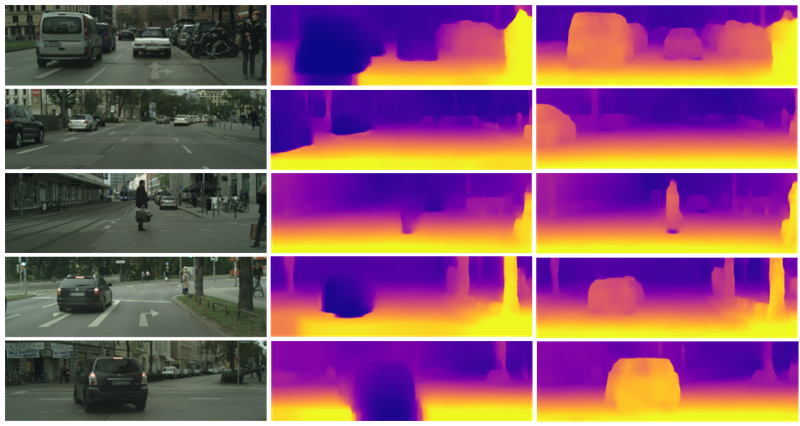

    딥러닝이 발전한 지금은 더 다양한 기술이 개발되어 있으니 잘 탐색해 보세요.
<br>


- (5) 다른 기술과 융합해 보기

    구글 pixel4에는 IR(적외선) 카메라가 달려있는데요. 물체의 온도를 측정하는 IR 카메라와 3D 이미지는 크게 관련이 없을 것 같지만, 이를 통해 보다 멋진 3d depth sensing이 가능하다는군요.<br><br>

    - [uDepth: Real-time 3D Depth Sensing on the Pixel 4](https://blog.research.google/2020/04/udepth-real-time-3d-depth-sensing-on.html)


    이렇게 카메라와 무관한 다른 기술과 융합하는 것도 좋은 해결책이 될 수 있습니다. 한 번 고민해 보세요!


이 외에도 다른 방식으로 접근해도 좋습니다. 엔지니어로서 본인이 선택한 솔루션을 잘 설명해 주세요. 가능하다면 순서도(Flow Chart)를 활용하면 좋습니다. 멋진 아이디어를 기대하겠습니다!!

</div>
</details>

### 흠

기본적으로 실제 렌즈를 활용해서 피사계심도를 표현한 게 아니라 segmentation모듈을 사용한 것이기에 classification의 accuracy가 완벽할 수 없다. 

노드에서 소개해준 3D기술을 활용해서 input의 차원을 늘려 classification의 정확도를 높여줄 수 있겠고 구글의 struct2Depth처럼 소프트웨어를 통해 심도를 파악할 수도 있다. 

하드웨어에는 한계가 있기 마련이라 이미지 마스킹의 accuracy를 높여줄 수 있는 모델을 만드는게 빠른 접근방법이라고 생각한다. 

pretrained모델인 deeplab을 가져온다는 전제로 진행된 프로젝트이기에, 심도를 파악하기 좋은 배경을 가진 새로운 데이터들을 불러와 이번 테스크에 맞는 학습을 다시 진행해서 모델을 업데이트해서 사용한다거나,,, 

blurring할 때 마스킹의 경계면에 0, 255외의 중간값을 할당해서 결과가 조금더 자연스럽게 보이게 한다던가,,,

## 회고
---

### 요약
이미지로 shallow focus와 비슷한 효과를 구현해보는 프로젝트이다. <br>
초점이 맞는 object를 찾아야 하기 때문에 테스크는 semantic segmentation이 되었고, 이 테스크를 수행하기 위한 모델로 DeepLabV3+가 사용되었다. 

object를 제외한 부분은 원거리의 표현을 위해 blur처리 해주었고, 원본의 object mask와 blurred background를 합성한 결과로 shallow focus와 비슷한 효과를 구현했다. 

### 과정

1. 필요한 라이브러리와 모델(deeplab)을 불러오고 모델에서 사용된 데이터셋(pascalvoc) label을 작성

2. 과정은 1)이미지를 로딩할 함수, 2)blurring을 위한 함수, 3)chromakey 배경전환을 위한 함수로 작성했다. 

    - (1) img_load( )
        1. 이미지 로딩
        2. 모델에 불러온 이미지 적용 -> object detect
        3. 찾은 object를 True, 나머지를 False로 마스킹
        4. 다시 True는 255, False는 0으로 마스킹
        5. 마스킹 데이터 리턴
        <br>

    - (2) img_bg_blur( )
        1. blur처리할 이미지 로딩
        2. cv2.blur( ): blurring 
        3. 흐려진 이미지에서 세그멘테이션 마스크(img_load return값)를 이용해서 배경만 추출
        4. np.where( ): object와 background 합성
        5. 합성된 이미지 리턴
        <br>
        
    - (3) bg_chromakey( )
        1. load object, background image
        2. background image 'resizing'
        3. 마스크이미지불러오고 배경이랑 합치기
        4. 합성된 이미지 리턴
        <br>


3. 작성한 함수에 이미지 파일을 loading하고 합성된 사진의 결과를 확인한다. 


### 결론

이미지를 찾고 마스킹한다음 배경과 합성하는 과정은 blurring이나 chromakey가 두 이미지를 합성하는 같은 방법을 사용했다.<br> 이미지는 잘 합성 되었지만 마스킹 경계면이나 object 중간에 작은 빈공간이 있는 경우에 마스킹이 완벽하지 않았다.<br> 실제 렌즈로 초점을 찾는 것과 달리 소프트웨어를 이용해 효과를 따라한 것이기 때문에 한계가 있다.<br> 이 문제를 해결하기 위해서 여러가지 방법이 있고 시도되는 것 같다.<br> 여러가지의 렌즈를 사용한 데이터를 인풋으로 넣어줘서 차원을 늘려주는 것이 이 테스크의 성능을 높여주지 않을까 싶다.

### 회고

exploration시작하고 처음으로 드디어 혼자서 뭘 해본거 같다.<br> 간단한 문제였지만 코딩경력이 거의 전무하기에 내방식대로 정리하고 미리 주어진 코드들 정리하고 <br>함수로 모듈화해서 문제를 풀어나갔다는게 모델에서 데이터 만들어내는것보다 재밌었다... <br>앞으로를 위해 과정을 파악하고 적용시킬수있는 내 나름의 템플릿을 만들어 두어야 겠다고 생각했다. 

